# Microsoft Stock Price Prediction

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
import matplotlib.dates as mdates
from scipy.stats import pearsonr

from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM

### Preprocessing

In [2]:
# Import Microsoft stock price dataset
msft = pd.read_csv('MSFT.csv')
msft['Date'] = pd.to_datetime(msft['Date'])
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-01-02,0.605903,0.616319,0.598090,0.616319,0.447268,53033600
1,1990-01-03,0.621528,0.626736,0.614583,0.619792,0.449788,113772800
2,1990-01-04,0.619792,0.638889,0.616319,0.638021,0.463017,125740800
3,1990-01-05,0.635417,0.638889,0.621528,0.622396,0.451678,69564800
4,1990-01-08,0.621528,0.631944,0.614583,0.631944,0.458607,58982400


### Normalize the Data (between 0 and 1)

In [3]:
msft_norm = msft.copy()
scaler = MinMaxScaler(feature_range = (0,1))
msft_norm[['Open', 'High', 'Low', 'Adj Close']] = scaler.fit_transform(msft_norm[['Open', 'High', 'Low', 'Adj Close']])
msft_norm.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-01-02,0.000129,0.000105,0.000129,0.616319,0.000115,53033600
1,1990-01-03,0.000265,0.000195,0.000273,0.619792,0.000137,113772800
2,1990-01-04,0.000249,0.000300,0.000288,0.638021,0.000253,125740800
3,1990-01-05,0.000386,0.000300,0.000334,0.622396,0.000154,69564800
4,1990-01-08,0.000265,0.000240,0.000273,0.631944,0.000214,58982400


# 1) Predicting tomorrow's closing price

In [4]:
features = ['Open', 'High', 'Low', 'Adj Close']

def offset_table(df, days):
    # Input: dataframe and days 
    # Output: The same dataframe, but with an extra Y column. The Y column is 'Adj Close' from the same table, but n days in advance

    x_temp = df[:-days].reset_index()[features]
    y_temp = df[days:].reset_index()['Adj Close']

    result = x_temp.join(y_temp, rsuffix='Y')
    result.rename({'Adj CloseY':'Y'}, axis='columns', inplace=True)
    return result

In [5]:
msft_offset = offset_table(msft_norm, 1)
msft_offset.head()

,Open,High,Low,Adj Close,Y
0,0.000129,0.000105,0.000129,0.000115,0.000137
1,0.000265,0.000195,0.000273,0.000137,0.000253
2,0.000249,0.000300,0.000288,0.000253,0.000154
3,0.000386,0.000300,0.000334,0.000154,0.000214
4,0.000265,0.000240,0.000273,0.000214,0.000203


In [6]:
# Pearson R coefficient
pearsonr(msft_offset['Low'], msft_offset['Y'])

PearsonRResult(statistic=0.9898373674470199, pvalue=0.0)

    The above cell calculates the Pearson R coefficient between OHLC and Adj Close for the next day. As expected, there is a strong correlation between the yesterday's OHLC numbers and tomorrow's closing stock prices

### Split into train and test

In [7]:
def train_test_split(df, train_ratio):
    # Input: Takes df; table and train_ratio; an int between 0 and 1 representing the ratio of train:test

    train_rows = round(df.shape[0] * train_ratio) # num of rows to train vs test
    
    train = df.iloc[0:train_rows, :]  # Splitting the data
    test = df.iloc[train_rows::, :]
    X_train, Y_train = train[features], train['Y']
    X_test, Y_test = test[features], test['Y']
    
    X_train = np.array(X_train) # Reformat
    X_test = np.array(X_test)

    X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    return X_tr_t, Y_train, X_tst_t, Y_test

In [8]:
X_train, Y_train, X_test, Y_test = train_test_split(msft_offset, 0.6)

### Build Model
    Input layer -> Hidden Layer (16 Nodes) -> Output layer.

In [9]:
K.clear_session()
model = Sequential()
model.add(LSTM(16, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

In [10]:
model.fit(X_train, Y_train, epochs=50, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/50
550/550 [==============================] - 1s 643us/step - loss: 1.3244e-04
Epoch 2/50
550/550 [==============================] - 0s 634us/step - loss: 4.5284e-04
Epoch 3/50
550/550 [==============================] - 0s 626us/step - loss: 2.2767e-04
Epoch 4/50
550/550 [==============================] - 0s 626us/step - loss: 1.0183e-04
Epoch 5/50
550/550 [==============================] - 0s 642us/step - loss: 5.0212e-05
Epoch 6/50
550/550 [==============================] - 0s 637us/step - loss: 3.2130e-05
Epoch 7/50
550/550 [==============================] - 0s 646us/step - loss: 2.7252e-05
Epoch 8/50
550/550 [==============================] - 0s 640us/step - loss: 2.4710e-05
Epoch 9/50
550/550 [==============================] - 0s 640us/step - loss: 2.4659e-05
Epoch 10/50
550/550 [==============================] - 0s 655us/step - loss: 2.3500e-05
Epoch 11/50
550/550 [==============================] - 0s 651us/step - loss: 2.4203e-05
Epoch 12/50
550/550 [====================

In [11]:
Y_train_pred = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(Y_train, Y_train_pred)))
r2_train = r2_score(Y_train, Y_train_pred)

Y_test_pred = model.predict(X_test)
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(Y_test, Y_test_pred)))
r2_test = r2_score(Y_test, Y_test_pred)

138/138 [==============================] - 0s 497us/step
The R2 score on the Train set is:	0.994
92/92 [==============================] - 0s 473us/step
The R2 score on the Test set is:	0.748


In [12]:
loss = model.evaluate(X_test, Y_test, batch_size=1)

2933/2933 [==============================] - 1s 449us/step - loss: 0.0121


In [13]:
Y_pred_test_LSTM = model.predict(X_test)

92/92 [==============================] - 0s 473us/step


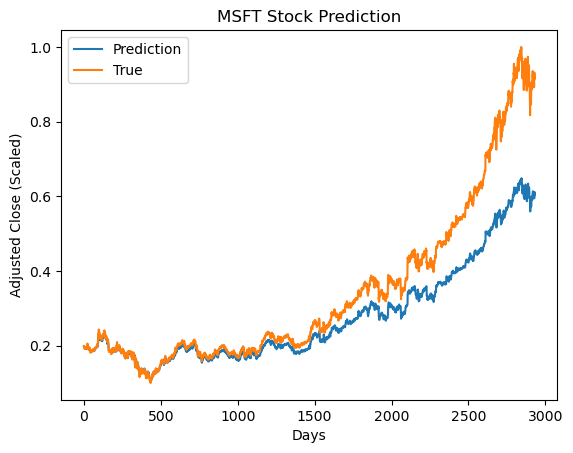

In [14]:
plt.plot(Y_pred_test_LSTM, label='Prediction')
plt.plot(Y_test.to_numpy(), label='True')
plt.title("MSFT Stock Prediction")
plt.xlabel('Days')
plt.ylabel('Adjusted Close (Scaled)')
plt.legend()
plt.show()

    The prediction is good at forecasting the stock price patterns, but tend to undervalue the stocks. This trend gets worse as time goes on, which is reasonable because it is a time series prediction. Because we are using the earliest 60% of the data to train the model, as we move further into the future, the less the training data reflects the test data, and so we see greater variance like the plot above.

# 2) Predicting next week's closing price 

In [15]:
msft_offset = offset_table(msft_norm, 5)
X_train, Y_train, X_test, Y_test = train_test_split(msft_offset, 0.6)

In [16]:
model.fit(X_train, Y_train, epochs=50, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/50
550/550 [==============================] - 1s 669us/step - loss: 6.7546e-05
Epoch 2/50
550/550 [==============================] - 0s 676us/step - loss: 6.6320e-05
Epoch 3/50
550/550 [==============================] - 0s 682us/step - loss: 6.7984e-05
Epoch 4/50
550/550 [==============================] - 0s 691us/step - loss: 6.9374e-05
Epoch 5/50
550/550 [==============================] - 0s 695us/step - loss: 7.0048e-05
Epoch 6/50
550/550 [==============================] - 0s 682us/step - loss: 7.0659e-05
Epoch 7/50
550/550 [==============================] - 0s 687us/step - loss: 7.0874e-05
Epoch 7: early stopping


In [17]:
Y_train_pred = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(Y_train, Y_train_pred)))
r2_train = r2_score(Y_train, Y_train_pred)

Y_test_pred = model.predict(X_test)
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(Y_test, Y_test_pred)))
r2_test = r2_score(Y_test, Y_test_pred)

138/138 [==============================] - 0s 482us/step
The R2 score on the Train set is:	0.968
92/92 [==============================] - 0s 484us/step
The R2 score on the Test set is:	0.535


In [18]:
loss = model.evaluate(X_test, Y_test, batch_size=1)
Y_pred_test_LSTM = model.predict(X_test)

92/92 [==============================] - 0s 484us/step


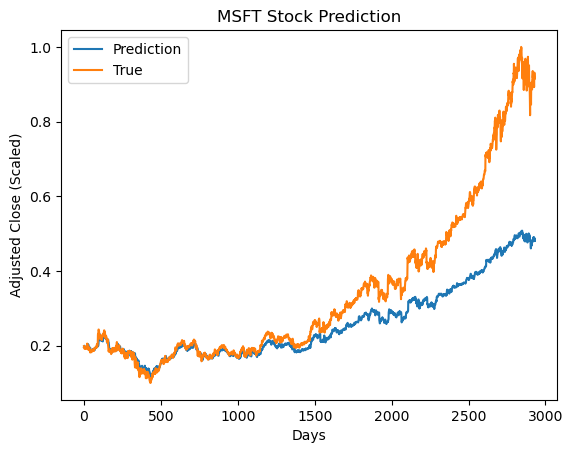

In [19]:
plt.plot(Y_pred_test_LSTM, label='Prediction')
plt.plot(Y_test.to_numpy(), label='True')
plt.title("MSFT Stock Prediction")
plt.xlabel('Days')
plt.ylabel('Adjusted Close (Scaled)')
plt.legend()
plt.show()

    As expected, predicting stock prices one week in the future is much more difficult. We see the recurring probelem of decreased accuracy over time, but with higher loss than before. The model is still able to predicts trends pretty accurately.

# 3) Predicting  Up or Down
